In [1]:
import sys
from typing import Callable, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

DATA_ROOT = '/mnt/ssd/data'

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                               ])

train_set = datasets.MNIST(DATA_ROOT, 
                           download=True, 
                           train=True,
                           transform=transform)
test_set = datasets.MNIST(DATA_ROOT, 
                          download=True, 
                          train=False,
                          transform=transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


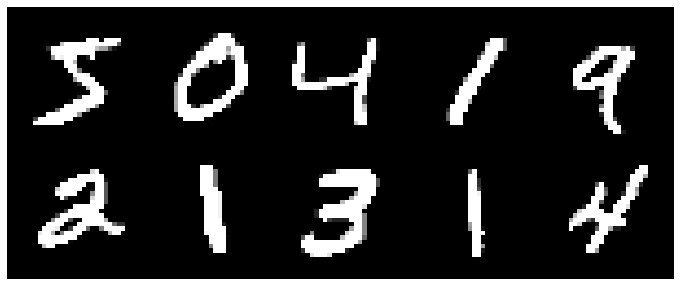

In [3]:
images = [train_set[i][0] for i in range(10)]
grid = make_grid(images, nrow=5)
fig, ax = plt.subplots(1, 1, figsize=(20,5))
ax.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.grid(False)

In [4]:
class LeNet5(nn.Module):

    def __init__(self, n_classes: int = 10):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=200),
            nn.Tanh(),
            nn.Linear(in_features=200, out_features=n_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [5]:
LR = 1e-3
WEIGHT_DECAY = 1e-4
N_CLASSES = 10
N_EPOCHS = 3
BATCH_SIZE = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def train_epoch(train_loader: DataLoader, model: nn.Module, criterion: Union[Callable, nn.Module], 
                optimizer: torch.optim.Optimizer, device: str = 'cpu') -> float:
    
    model.train()
    accs = []
    
    pbar = tqdm(enumerate(train_loader), file=sys.stdout)
    for batch_idx, (X, y) in pbar:
        optimizer.zero_grad()
        
        X = X.to(device)
        y = y.to(device)
    
        logits, probs = model(X)
        loss = criterion(logits, y)
        
        loss.backward()
        optimizer.step()
        
        pred = probs.detach().argmax(dim=1)
        acc = (pred == y).sum() / len(probs)
        accs.append(acc.item())

        pbar.set_description(f'Acc: {acc}')

    acc = np.mean(accs)
    
    return acc

In [7]:
def validate(valid_loader: DataLoader, model: nn.Module, device: str = 'cpu') -> float:

    model.eval()
    accs = []
    
    pbar = tqdm(valid_loader, file=sys.stdout)
    for X, y in pbar:
    
        X = X.to(device)
        y = y.to(device)

        logits, probs = model(X) 
        pred = probs.detach().argmax(dim=1)
        acc = (pred == y).sum() / len(probs)
        accs.append(acc.item())

        pbar.set_description(f'Acc: {acc}')
        
    acc = np.mean(accs)
    
    return acc

In [8]:
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

model = LeNet5(n_classes=N_CLASSES).to(DEVICE)
criterion = nn.CrossEntropyLoss().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

In [9]:
train_accs, test_accs = [], []

for e in range(N_EPOCHS):
    train_acc = train_epoch(train_loader, model, criterion, optimizer, DEVICE)
    test_acc = validate(test_loader, model, DEVICE)
    
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    
    print(f'Train Acc: {train_acc} | Test Acc: {test_acc}')

Acc: 1.0: : 1875it [00:10, 181.62it/s]    
Acc: 1.0: 100%|██████████| 313/313 [00:01<00:00, 256.22it/s]    
Train Acc: 0.9325333333333333 | Test Acc: 0.9674520766773163
Acc: 1.0: : 1875it [00:10, 183.21it/s]    
Acc: 1.0: 100%|██████████| 313/313 [00:01<00:00, 250.44it/s]    
Train Acc: 0.9733666666666667 | Test Acc: 0.9739416932907349
Acc: 1.0: : 1875it [00:10, 182.68it/s]    
Acc: 1.0: 100%|██████████| 313/313 [00:01<00:00, 252.71it/s]    
Train Acc: 0.9803166666666666 | Test Acc: 0.9821285942492013


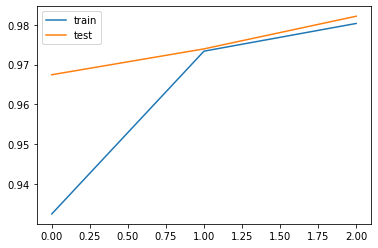

In [10]:
plt.plot(train_accs, label='train')
plt.plot(test_accs, label='test')
plt.legend()